In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import sys
# sys.path.insert(1, '../src')
import algorithm as al

In [2]:
print(cv2.getBuildInformation())


General configuration for OpenCV 4.10.0 =====================================
  Version control:               unknown

  Extra modules:
    Location (extra):            /tmp/pip-install-q_5601f_/opencv-contrib-python-headless_8899128e35a84dcb90525b8113d5a9a5/opencv_contrib/modules
    Version control (extra):     unknown

  Platform:
    Timestamp:                   2024-11-20T04:43:55Z
    Host:                        Linux 6.8.0-45-generic x86_64
    CMake:                       3.31.0
    CMake generator:             Ninja
    CMake build tool:            /usr/bin/ninja
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2 AVX512_SKX
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (16 files):         + SSSE3 SSE4_1
      SSE4_2 (1 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      FP16 (0 file

In [3]:
sample_input = '/home/saratoga/swt2_data/shegreat_0020.png'
sample_input_line = '/home/saratoga/swt2_data/line.png'
sample_input_line_2 = '/home/saratoga/swt2_data/line2.png'

# sample_input = '/home/saratoga/swt2_data/AisazuNihaIrarenai-009.jpg'
# sample_input_line = sample_input

def visualize(poly, background):
    bg = background.copy()
    # print(chains.shape)
    # print(np.array(poly).shape)
    cv2.polylines(bg, poly, True, (0, 255, 0), 2)
    plt.clf()
    plt.imshow(bg)
    return plt

def visualize_method(img, method, background=None, output_name=None):
    bg = img if background is None else background
    chars, chains, seperated = method.process(img)
    # print(chars)
    plt = visualize(chars if seperated else chains, bg)
    if output_name is not None:
        plt.savefig(output_name + '-' + method.__class__.__name__ + '.png')

img = cv2.imread(sample_input)
line = cv2.imread(sample_input_line)
line2 = cv2.imread(sample_input_line_2)

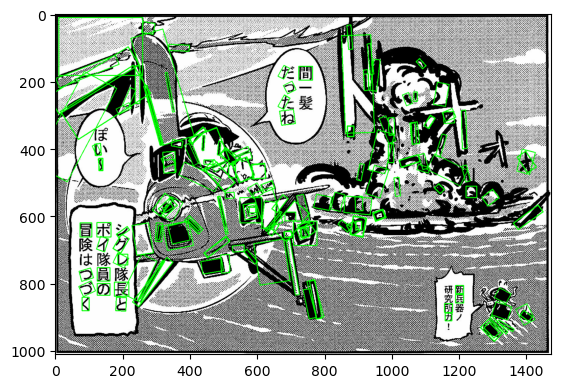

In [4]:
mode = al.Text_ER()
visualize_method(line, mode, img)

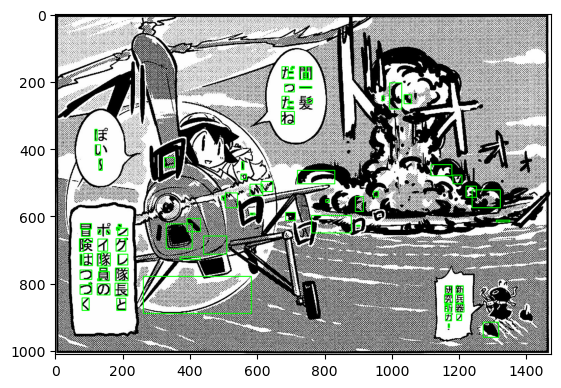

In [5]:
visualize_method(line, al.Text_SWT(), img)

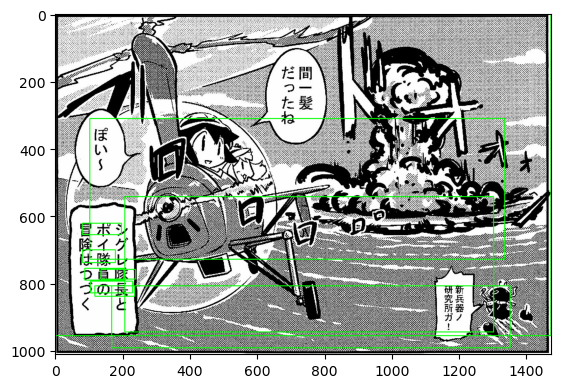

In [6]:
# print(dir(al))
visualize_method(line, al.Text_CNNTextBoxes(), img)

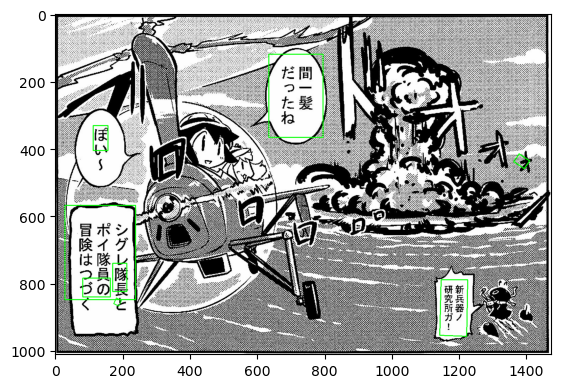

In [7]:
visualize_method(line, al.DNN_DB(), img)

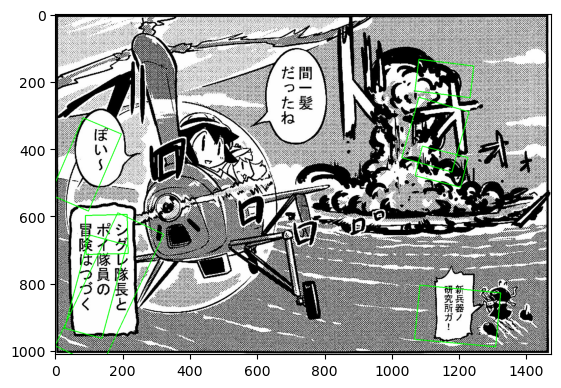

In [8]:
visualize_method(line, al.DNN_EAST(), img)

In [9]:
import glob
from pathlib import Path
import algorithm as al

def run(img_name, root, out_base):
    p = Path(img_name).relative_to(root)
    img = cv2.imread(img_name)
    line = img
    out = out_base / p
    print(img_name, '=>', out)
    out.parent.mkdir(parents=True, exist_ok=True)
    out.parents[1]
    out = str(out)
    return
    visualize_method(line, al.Text_ER(), img, out)
    visualize_method(line, al.Text_SWT(), img, out)
    visualize_method(line, al.Text_CNNTextBoxes(), img, out)
    visualize_method(line, al.DNN_DB(), img, out)
    visualize_method(line, al.DNN_EAST(), img, out)

base = '/home/saratoga/swt2_data/mantra_output/'
root = '/home/saratoga/swt2_data/open-mantra-dataset/'
test_set = glob.glob('/home/saratoga/swt2_data/open-mantra-dataset/images/**/*.jpg', recursive=True)

# print(test_set)
# for test in test_set:
#     run(test, root, base)
    # break


In [10]:
import json
with open('/home/saratoga/swt2_data/open-mantra-dataset/annotation.json', 'r') as fd:
    anno = json.loads(fd.read())

In [11]:
from pathlib import Path
from shapely import Polygon, intersection, union, normalize, MultiPolygon
import numpy as np
# method.process(img)
def convert_polygon_to_points(p):
    pts = np.array([x for x in p.exterior.coords][:-1], dtype=np.int32)
    pts.reshape((-1, 1, 2))
    # print(pts)
    return pts

def condense(bbs):
    while True:
        condensed = []
        for bb in bbs:
            if not bb.area > 0:
                continue
            if not bb.is_valid:
                print("WARN invalid polygon {}".format(bb))
            count = 0
            for i in range(len(condensed)):
                c = condensed[i]
                if bb.overlaps(c) and bb.intersects(c):
                    condensed[i] = normalize(c.union(bb))
                    assert condensed[i].geom_type == "Polygon", "{} intersecs {} seems impossible {}".format(c, bb, condensed[i])
                else:
                    count += 1
            if count == len(condensed):
                condensed.append(bb)
                
        if len(bbs) == len(condensed):
            break
        bbs = condensed
    return condensed

def collide(image_name, method, known_bbs):
    img = cv2.imread(image_name)
    chars, chains, sep = method.process(img)
    tp = []
    # fp = []
    # fn = []
    polys = condense([Polygon(bb) for bb in chars])
    # print(polys)
    bbs = condense([Polygon(bb) for bb in known_bbs])
    a = np.sum([poly.area for poly in polys])
    b = np.sum([bb.area for bb in bbs])
    for poly in polys:
        match = 0
        for bb in bbs:
            intersect = normalize(poly.intersection(bb))
            # print("Intersect", intersect.area)
            match += intersect.area
            # missing += bb.area - a
        # print(match, missing, poly.area)
        # wrong_match = poly.area - match
        # assert wrong_match > 0
        # if wrong_match < 0:
        #     print("WARN wrong_match", wrong_match)
        #     wrong_match = 0

        tp.append(match)
        # fp.append(wrong_match)
        # fn.append(missing)

    tps = np.sum(tp)
    fps = a - tps
    fns = b - tps
    if fps < 0:
        print("WARN fps", fps)
        fps = 0
    if fns < 0:
        print("WARN fns", fns)
        fns = 0
    # visualize([convert_polygon_to_points(poly) for poly in polys], img)
    # visualize([convert_polygon_to_points(poly) for poly in bbs], img)

    return (tps, fps, fns)

def stats(x):
    tp, fp, fn = x
    # if tp < 0:
    #     print("WARN tp < 0")
    # if fp < 0:
    #     print("WARN fp < 0")
    # if fn < 0:
    #     print("WARN fn < 0")
    precision = 0 if (tp + fp == 0) else tp / (tp + fp)
    recall = 0 if (tp + fn == 0) else tp / (tp + fn)
    f1 =  0 if precision + recall == 0 else (2 * precision * recall) / (precision + recall)
    return (precision, recall, f1)

def run_mass(TARGET=None):
    root = '/home/saratoga/swt2_data/open-mantra-dataset/'
    total = np.array((0., 0., 0.))
    depth = 0
    for book in anno:
        title = book["book_title"]
        for page in book["pages"]:
            depth += 1
            if TARGET is not None and depth != TARGET:
                continue
            page_no = page["page_index"]
            img_path = Path(root) / page["image_paths"]["ja"]
            bbs = []
            for text in page["text"]:
                rect = (text["x"], text["y"], text["w"], text["h"])
                bbs.append(al.rect_to_points(rect))
            # print(bb)
            m = al.Text_ER()
            # al.enable_CUDA(m)
            z = collide(img_path, m, bbs)
            total += stats(z)
            if depth == TARGET:
                return total
    return total/depth
                

print(run_mass())
# DB [0.74591527 0.05696854 0.09671098]

# EAST [0.10752163 0.01610562 0.02531817]
# SWT [0.2821221  0.00052111 0.00103782]
# ER [0.11604181 0.00929692 0.01539698]
# TextBoxes [0.10149707 0.71080543 0.1654614 ]

# Improved
# DB [0.74626367 0.05491366 0.0938761 ]
# EAST [0.10752163 0.01610562 0.02531817]
# ER [0.11335229 0.00956246 0.01550481]
# SWT [0.28213893 0.00051337 0.00102253]
# TextBoxes [0.10692051 0.51372485 0.16243599]

# Correct number
# DB [0.74605163 0.22481251 0.32306157]
# EAST [0.10745574 0.03709625 0.04767068]
# ER [0.11315557 0.84735446 0.19142319]
# SWT [0.28196898 0.13095646 0.16871642]
# TextBoxes [0.10660832 0.86393177 0.18541365]

WARN fns -3342.843074517805
WARN fns -421372.7524033836
WARN fns -467910.51154530514
WARN fns -14799.861786502355
WARN fns -31169.817688962852
WARN fns -102430.78736949325
WARN fns -13154.868785044004
WARN fns -81937.01994719601
WARN fns -17017.239091467578
WARN fns -115909.0883063986
WARN fns -85233.40768566783
WARN fns -8996.0
WARN fns -61776.11363636363
WARN fns -2179.9826771782537
WARN fns -27141.580821032287
WARN fns -100403.09765536082
WARN fns -66531.9610424064
WARN fns -100414.86440865806
WARN fns -55447.027030016296
WARN fns -39790.93623188406
WARN fns -24500.66454278893
WARN fns -43946.036334806704
WARN fns -13475.64968617892
WARN fns -150466.74469260185
WARN fns -117325.89534410299
WARN fns -61791.350000000006
WARN fns -4720.38012611962
WARN fns -3738.086493965762
WARN fns -77743.0417768168
WARN fns -54612.26621571509
WARN fns -132545.85883216152
WARN fns -53619.35717746659
WARN fns -1840.5097107316833
WARN fns -37013.63276206258
WARN fns -13749.851159780344
WARN fns -13219.

In [12]:
cv2.cuda.getCudaEnabledDeviceCount()

1

In [13]:
# Edge cases below

True
False
0.0


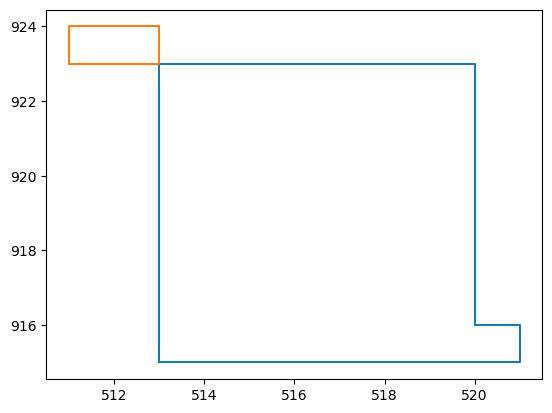

In [14]:
from shapely.geometry import Polygon
from shapely.wkt import loads
import matplotlib.pyplot as plt
p1 = loads("POLYGON ((513 915, 513 923, 520 923, 520 916, 521 916, 521 915, 520 915, 519 915, 513 915))")
p2 = loads("POLYGON ((511 923, 513 923, 513 924, 511 924, 511 923))")
print(p1.intersects(p2))
print(p1.overlaps(p2))
print(p1.intersection(p2).area)
plt.plot(*p1.exterior.xy)
plt.plot(*p2.exterior.xy)

117.0 0.0
True
True


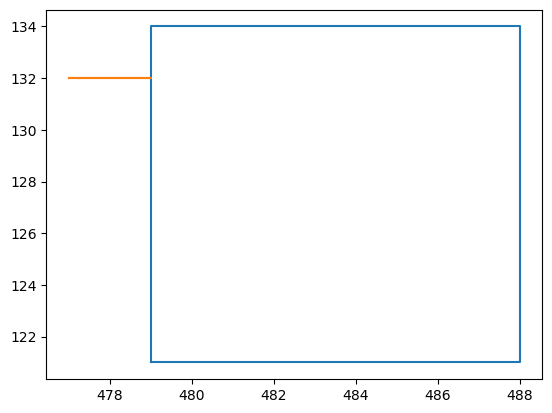

In [15]:
from shapely.geometry import Polygon
from shapely.wkt import loads
import matplotlib.pyplot as plt
p1 = loads("POLYGON ((479 121, 488 121, 488 134, 479 134, 479 121))")
p2 = loads("POLYGON ((477 132, 479 132, 479 132, 477 132))")
p2 = normalize(p2)
print(p1.area, p2.area)
print(p1.intersects(p2))
print(p1.overlaps(p2))
print(p1.intersection(p2).area)
plt.plot(*p1.exterior.xy)
plt.plot(*p2.exterior.xy)

328.0 1184.0
True
True


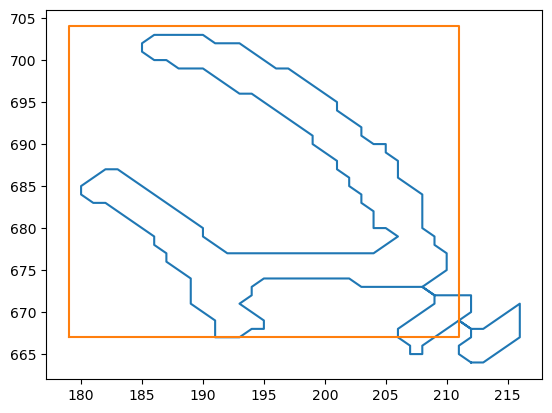

In [16]:
from shapely.geometry import Polygon
from shapely.wkt import loads
import matplotlib.pyplot as plt
p1 = loads("POLYGON ((212 664, 211 665, 211 666, 212 667, 212 668, 211 669, 208 666, 208 665, 207 665, 207 666, 206 667, 206 668, 209 671, 209 672, 208 673, 203 673, 202 674, 195 674, 194 673, 194 672, 193 671, 195 669, 195 668, 194 668, 193 667, 191 667, 191 669, 189 671, 189 674, 187 676, 187 677, 186 678, 186 679, 182 683, 181 683, 180 684, 180 685, 182 687, 183 687, 190 680, 190 679, 192 677, 204 677, 206 679, 205 680, 204 680, 204 682, 203 683, 203 684, 202 685, 202 686, 201 687, 201 688, 199 690, 199 691, 194 696, 193 696, 190 699, 188 699, 187 700, 186 700, 185 701, 185 702, 186 703, 190 703, 191 702, 193 702, 196 699, 197 699, 201 695, 201 694, 203 692, 203 691, 204 690, 205 690, 205 689, 206 688, 206 686, 208 684, 208 680, 209 679, 209 678, 210 677, 210 675, 208 673, 209 672, 212 672, 212 670, 211 669, 212 668, 213 668, 216 671, 216 667, 213 664, 212 664))")
p2 = loads("POLYGON ((179 667, 211 667, 211 704, 179 704, 179 667))")
print(p1.area, p2.area)
print(p1.intersects(p2))
print(p1.overlaps(p2))
print(p1.intersection(p2).area)
plt.plot(*p1.exterior.xy)
plt.plot(*p2.exterior.xy)

770.0 770.0
True
False


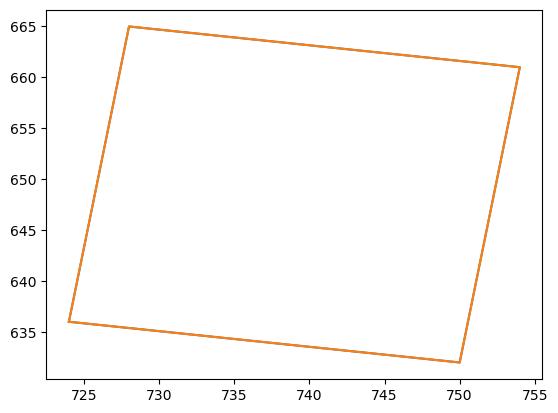

In [17]:
from shapely.geometry import Polygon
from shapely.wkt import loads
import matplotlib.pyplot as plt
p1 = loads("POLYGON ((724 636, 750 632, 754 661, 728 665, 724 636))")
p2 = loads("POLYGON ((724 636, 750 632, 754 661, 728 665, 724 636))")
print(p1.area, p2.area)
print(p1.intersects(p2))
print(p1.overlaps(p2))
print(p1.intersection(p2).area)
plt.plot(*p1.exterior.xy)
plt.plot(*p2.exterior.xy)

4692.0 4556.0
True
False


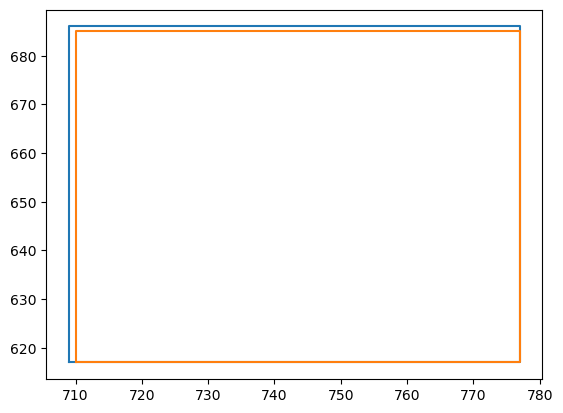

In [18]:
from shapely.geometry import Polygon
from shapely.wkt import loads
import matplotlib.pyplot as plt
p1 = loads("POLYGON ((709 617, 777 617, 777 686, 709 686, 709 617))")
p2 = loads("POLYGON ((710 617, 777 617, 777 685, 710 685, 710 617))")
print(p1.area, p2.area)
print(p1.intersects(p2))
print(p1.overlaps(p2))
print(p1.intersection(p2).area)
plt.plot(*p1.exterior.xy)
plt.plot(*p2.exterior.xy)